# Abalone Age Prediction

<img src="Abalone.jpg">

## About the Abalone Dataset
Abalone are a type of sea snail. Determining the age of an abalone is classically done by cutting the shell and counting the number of rings through a microscope. The goal of this analysis is to use easier to measure characteristics to predict the age, and speed up this tedious task.

The data comes from a repository [here](https://archive.ics.uci.edu/ml/datasets/Abalone), which includes more information about the dataset. Each row of the data is complete and represents the measurements of an individual abalone, alongside it's number of rings. The age in years is simply the number of rings plus 1.5.

# 0. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import  train_test_split, cross_val_score, RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import  RandomForestRegressor
from sklearn.ensemble import  GradientBoostingRegressor
from sklearn.linear_model import  Ridge
from sklearn.svm import SVR
from sklearn.model_selection import  GridSearchCV
from sklearn import metrics

import statsmodels.api as sm

from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

# 1. Data Ingestion and Preprocessing

## 1.1 Import Raw Data

In [2]:
df = pd.read_csv('data/raw/abalone.csv')

## 1.2 Add column names and calculate age
Column names come from the data [repository](https://archive.ics.uci.edu/ml/datasets/Abalone)

	Name            Data Type	Meas.	Description
	----			---------	-----	-----------
	Sex             nominal				M, F, and I (infant)
	Length          continuous	mm       Longest shell measurement
	Diameter        continuous	mm       perpendicular to length
	Height          continuous	mm       with meat in shell
	Whole weight    continuous	grams	whole abalone
	Shucked weight  continuous	grams	weight of meat
	Viscera weight  continuous	grams	gut weight (after bleeding)
	Shell weight    continuous	grams	after being dried
	Rings           integer				+1.5 gives the age in years

In [3]:
df.columns = ['Sex', 'Length', 'Diameter', 'Height', 'Whole Weight', 'Shucked Weight',
              'Viscera Weight', 'Shell Weight', 'Rings']
df['Age'] = df['Rings'] + 1.5
df.drop(columns = 'Rings', inplace=True)

# 2. Exploratory Data Analysis 

## 2.1 Exploring the dataset with Univariate Analysis

In [4]:
df.head()

,Sex,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,8.5
1,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,10.5
2,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,11.5
3,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,8.5
4,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,9.5


In [5]:
df.shape

(4176, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4176 entries, 0 to 4175
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4176 non-null   object 
 1   Length          4176 non-null   float64
 2   Diameter        4176 non-null   float64
 3   Height          4176 non-null   float64
 4   Whole Weight    4176 non-null   float64
 5   Shucked Weight  4176 non-null   float64
 6   Viscera Weight  4176 non-null   float64
 7   Shell Weight    4176 non-null   float64
 8   Age             4176 non-null   float64
dtypes: float64(8), object(1)
memory usage: 293.8+ KB


In [7]:
df.describe()

,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,4176.000000,4176.000000,4176.000000,4176.000000,4176.00000,4176.000000,4176.000000,4176.000000
mean,0.524009,0.407892,0.139527,0.828818,0.35940,0.180613,0.238852,11.432471
std,0.120103,0.099250,0.041826,0.490424,0.22198,0.109620,0.139213,3.223601
min,0.075000,0.055000,0.000000,0.002000,0.00100,0.000500,0.001500,2.500000
25%,0.450000,0.350000,0.115000,0.441500,0.18600,0.093375,0.130000,9.500000
50%,0.545000,0.425000,0.140000,0.799750,0.33600,0.171000,0.234000,10.500000
75%,0.615000,0.480000,0.165000,1.153250,0.50200,0.253000,0.329000,12.500000
max,0.815000,0.650000,1.130000,2.825500,1.48800,0.760000,1.005000,30.500000


In [8]:
df.isnull().sum()

Sex               0
Length            0
Diameter          0
Height            0
Whole Weight      0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
Age               0
dtype: int64

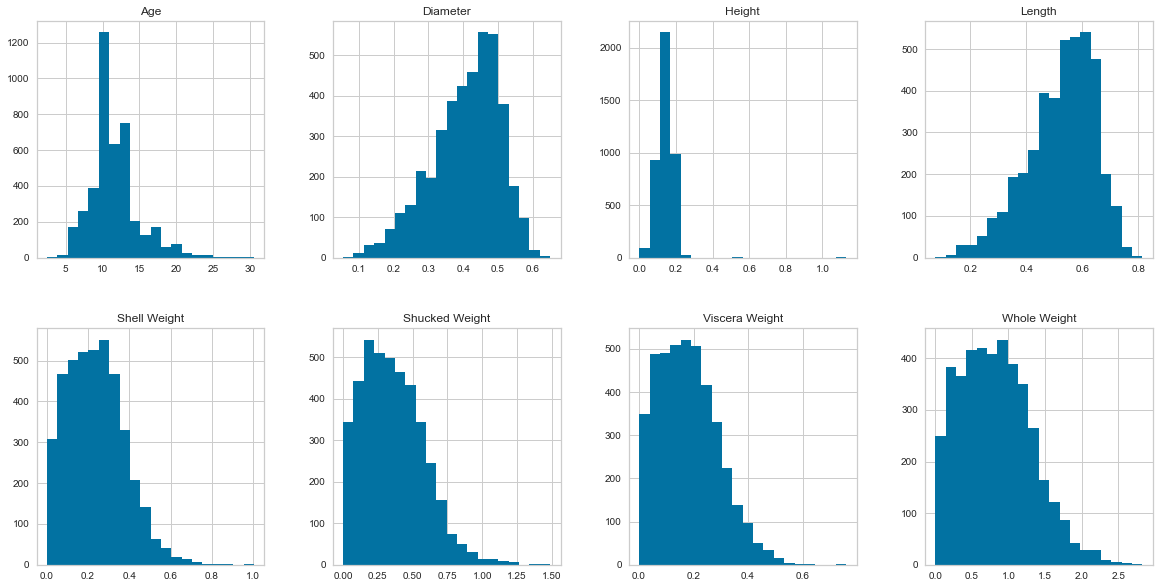

In [9]:
df.hist(figsize=(20,10), layout=(2, 4), bins = 20)
plt.show()

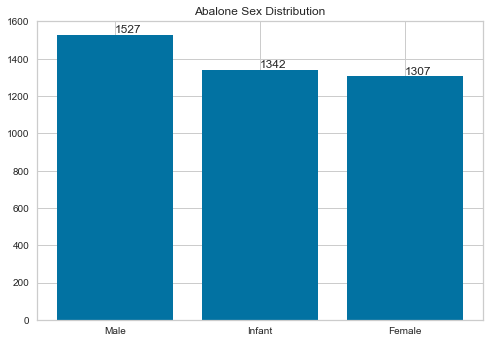

In [10]:
df.replace({'Sex': {'M': 'Male', 'F': 'Female', 'I': 'Infant'}}, inplace=True)
abalone_sex = df['Sex'].value_counts()
plt.bar(abalone_sex.index, abalone_sex)
plt.title('Abalone Sex Distribution')
for i, count in enumerate(abalone_sex):
    plt.annotate(count, xy=(abalone_sex.index[i],count*1.008))
plt.show()

## 2.1.1 Univariate Dataset Summary

This dataset has 4176 abalones with 8 features as well as Age. Each feature is numeric, except for Sex. The numeric features don't appear to be normally distributed, but are close in range.

## 2.2 Bivariate Analysis

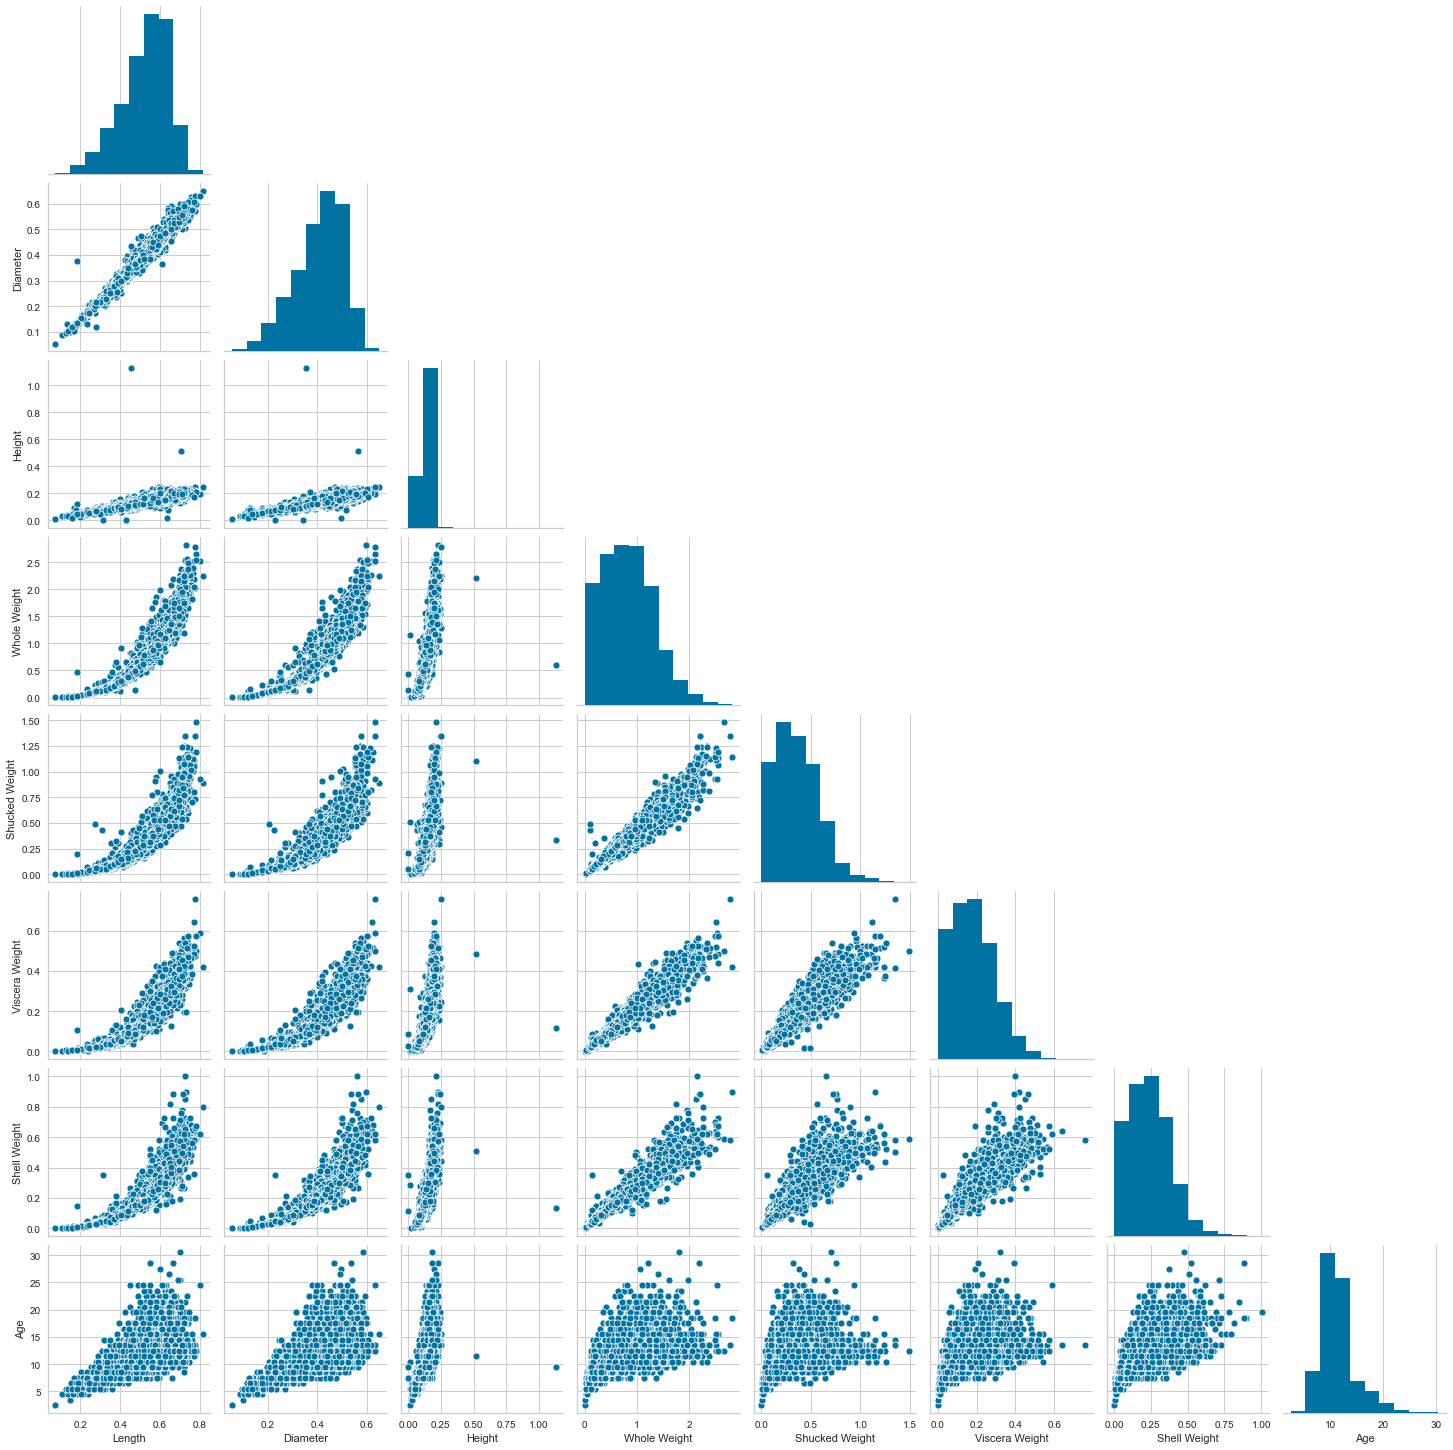

In [11]:
sns.set_context(font_scale=1.5)
sns.pairplot(df, corner=True) #requires seaborn v0.11
plt.show()

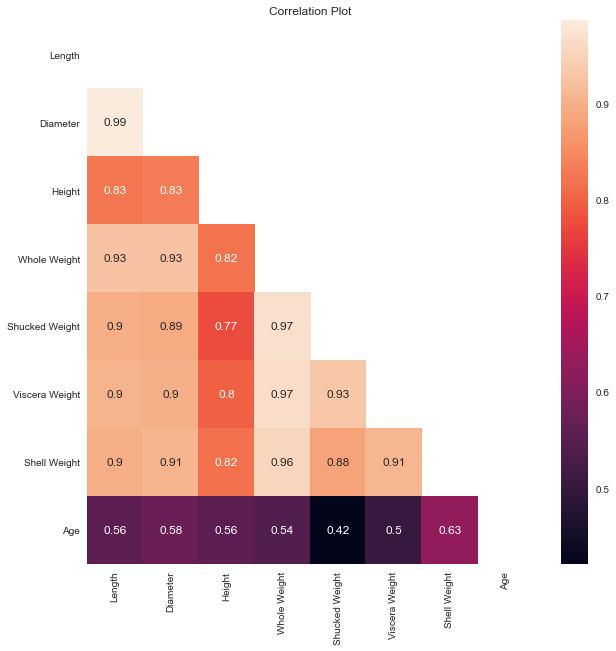

In [12]:
plt.figure(figsize=(10,10))
plt.title('Correlation Plot')
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True)
plt.show()

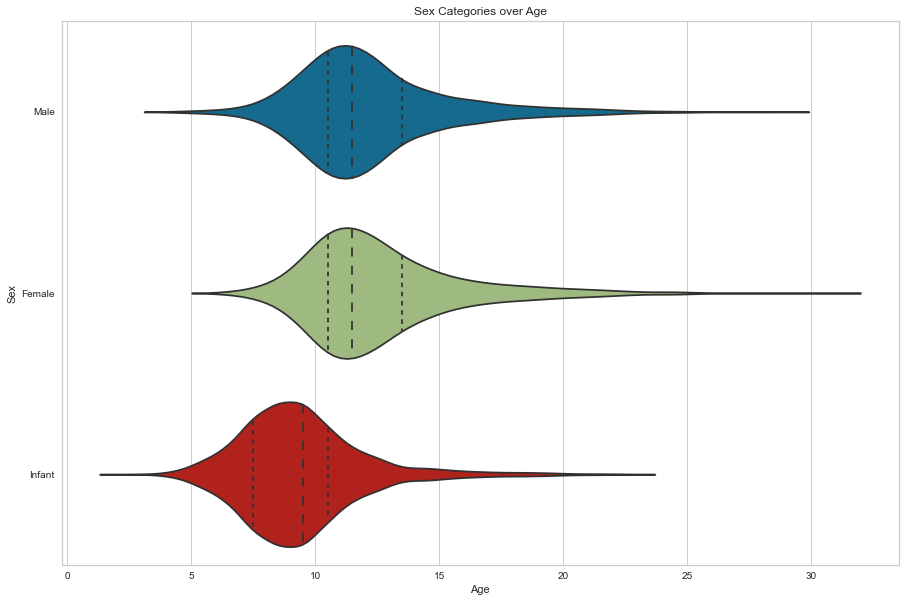

In [13]:
fig, ax = plt.subplots(figsize=(15,10))
plt.title('Sex Categories over Age')
sns.violinplot(y='Sex', x='Age', data=df, inner='quartile')
plt.show()

## 2.2.1 Bivariate Analysis Summary
There are some outliers in the data, most notably in the Height. There is a significant amount of multicolinearity in all the features. Age is most correlated with Shell Weight, and least correlated with Shucked Weight. Visually the sex doesn't have an impact on age unless the abalone are infants.

# 3. Data Preparation 

## 3.1 Outliers

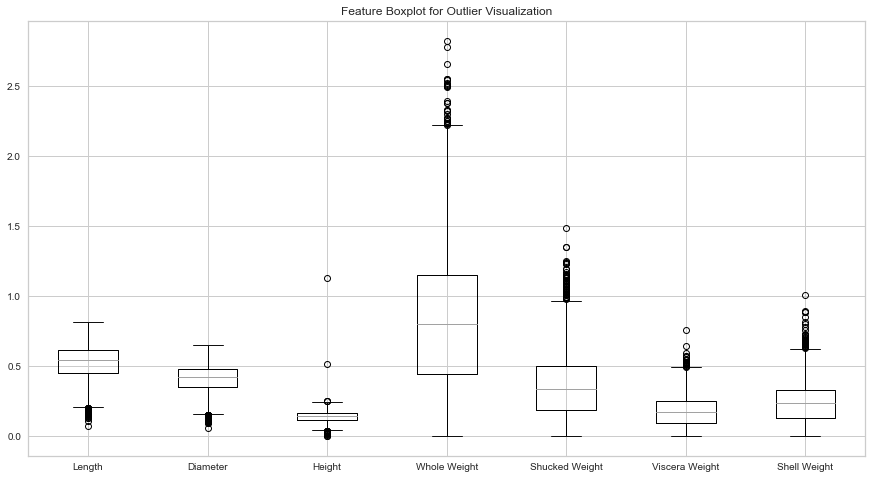

In [14]:
plt.figure(figsize=(15,8))
plt.title('Feature Boxplot for Outlier Visualization')
df.drop('Age', axis=1).boxplot()
plt.show()

As we saw earlier we do have some outliers, but we will keep all the data to see if they provide us any useful information.

## 3.2 Normalization
Normalization on this dataset isn't strictly necessary as the ranages of the features are very similar. We'll still normalize the data as a best practice.

In [15]:
minmax=MinMaxScaler()
feature_norm=pd.DataFrame(minmax.fit_transform(df.drop(['Sex', 'Age'],axis=1)),columns=['Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight'])
feature_norm.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight
0,0.371622,0.352941,0.079646,0.079157,0.066241,0.063199,0.068261
1,0.614865,0.613445,0.119469,0.239065,0.171822,0.185648,0.207773
2,0.493243,0.521008,0.110619,0.182044,0.144250,0.149440,0.152965
3,0.344595,0.336134,0.070796,0.071897,0.059516,0.051350,0.053313
4,0.472973,0.411765,0.084071,0.123783,0.094149,0.101382,0.118087


In [16]:
df = feature_norm.join(df[['Sex', 'Age']])

## 3.3 Categorical Column Encoding
In order to analyze the sex of the abalone the categories need to be converted to something our algorithms can work with. Here we use one-hot encoding as Sex has no natural ordering.

In [17]:
SexCategories = pd.get_dummies(df['Sex'])
df = df.drop('Sex',axis=1).join(SexCategories)

In [18]:
df.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age,Female,Infant,Male
0,0.371622,0.352941,0.079646,0.079157,0.066241,0.063199,0.068261,8.5,0,0,1
1,0.614865,0.613445,0.119469,0.239065,0.171822,0.185648,0.207773,10.5,1,0,0
2,0.493243,0.521008,0.110619,0.182044,0.144250,0.149440,0.152965,11.5,0,0,1
3,0.344595,0.336134,0.070796,0.071897,0.059516,0.051350,0.053313,8.5,0,1,0
4,0.472973,0.411765,0.084071,0.123783,0.094149,0.101382,0.118087,9.5,0,1,0


## 3.4 Splitting into test and training sets

In [19]:
X = df.drop('Age', axis = 1)
y = df['Age']

random_state = 42 #setting a random state for consistency in other comparisons
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=random_state)

# 4. Modelling and Model Evaluation

In [20]:
def ModelRMSE(model, X_train, y_train, cv, scorerObject):
    rmse =- (cross_val_score(model, X_train, y_train, scoring=scorerObject, cv=cv))
    return(rmse)

modelDict = {'Linear Regression': LinearRegression(), 'Ridge Regression': Ridge(random_state=random_state),
             'Support Vector Regressor': SVR(), 'Random Forest Regressor': RandomForestRegressor(random_state=random_state),
             'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=random_state),
             'K Nearest Neigbours Regressor': KNeighborsRegressor(n_neighbors = 4)}
# models = [LinearRegression(),
#              Ridge(random_state=random_state),
#              SVR(),
#              RandomForestRegressor(random_state=random_state),
#              GradientBoostingRegressor(random_state=random_state),
#              KNeighborsRegressor(n_neighbors = 4)]

# names = ['Linear Regression','Ridge Regression','Support Vector Regressor',
#          'Random Forest Regressor', 'Gradient Boosting Regressor','K Nearest Neigbours Regressor']

model_df = pd.DataFrame(columns=['Name', 'RMSE', 'Standard Deviation'])
rows_list = []
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=random_state)
scorerObject = 'neg_root_mean_squared_error'

# for model,name in zip(models,names):
for name, model in modelDict.items():
    rmse = ModelRMSE(model, X_train, y_train, cv, scorerObject)
    rows_list.append([name, rmse.mean(), rmse.std()])
    
model_df = pd.DataFrame(rows_list, columns=['Name', 'RMSE', 'Standard Deviation'])
model_df.set_index('Name', inplace=True, drop=True)
model_df.sort_values(by='RMSE', inplace=True, ignore_index=False)
model_df

,RMSE,Standard Deviation
Name,,
Random Forest Regressor,2.183783,0.100686
Gradient Boosting Regressor,2.185889,0.098004
Ridge Regression,2.232697,0.084649
Linear Regression,2.236007,0.088948
K Nearest Neigbours Regressor,2.331388,0.096351
Support Vector Regressor,2.333302,0.115900


The Random Forest Regressor is the best performing algorithm accross the cross validation testing. We'll select it going forward.

# 5. Visualization, Inspection and Hyperparameter Tuning

In [21]:
baseModel = RandomForestRegressor()
modelName = 'Random Forest Regressor'
baseModel.fit(X_train, y_train)
y_pred = baseModel.predict(X_test)

In [22]:
def pred_vs_actual(X_test, y_test, model, modelName):
    y_pred = model.predict(X_test)
    fig = plt.figure(figsize=(5,5))
    plt.scatter(y_pred, y_test)
    plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()], c='r')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    title = modelName + ' - Predicted vs Actual'
    plt.title(title)
    plt.show()
    
    print('Train Score: %.3f' % model.score(X_train, y_train))
    print('Test Score: %.3f' % model.score(X_test, y_test))

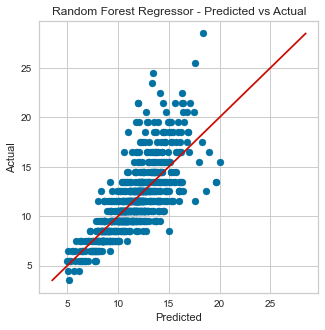

Train Score: 0.934
Test Score: 0.569


In [23]:
pred_vs_actual(X_test, y_test, baseModel, modelName)

## 5.1 Hyperparameter Tuning

In [24]:
param_grid = {
    'max_depth': [10, 100],
    'max_features': [3,4, 5],
    'min_samples_leaf': [3, 4],
    'n_estimators': [100, 1000]
}

grid_search = GridSearchCV(estimator = baseModel, param_grid = param_grid, 
                           scoring=scorerObject, cv = cv, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)
print('Grid Search Best Parameters')
print(grid_search.best_params_)

Fitting 15 folds for each of 24 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.9min finished


Grid Search Best Parameters
{'max_depth': 100, 'max_features': 5, 'min_samples_leaf': 4, 'n_estimators': 1000}


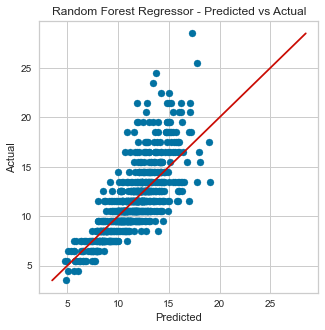

Train Score: 0.792
Test Score: 0.583


In [25]:
tunedModel = RandomForestRegressor(max_depth=grid_search.best_params_['max_depth'],
            max_features=grid_search.best_params_['max_features'],
            min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
            n_estimators=grid_search.best_params_['n_estimators'],
            random_state=random_state).fit(X_train, y_train)

pred_vs_actual(X_test, y_test, tunedModel, modelName)

Cross Validation RMSE : Mean - 2.135 | Std - 0.104 | Min - 1.943 | Max - 2.323


Text(0, 0.5, 'Feature Importance Score')

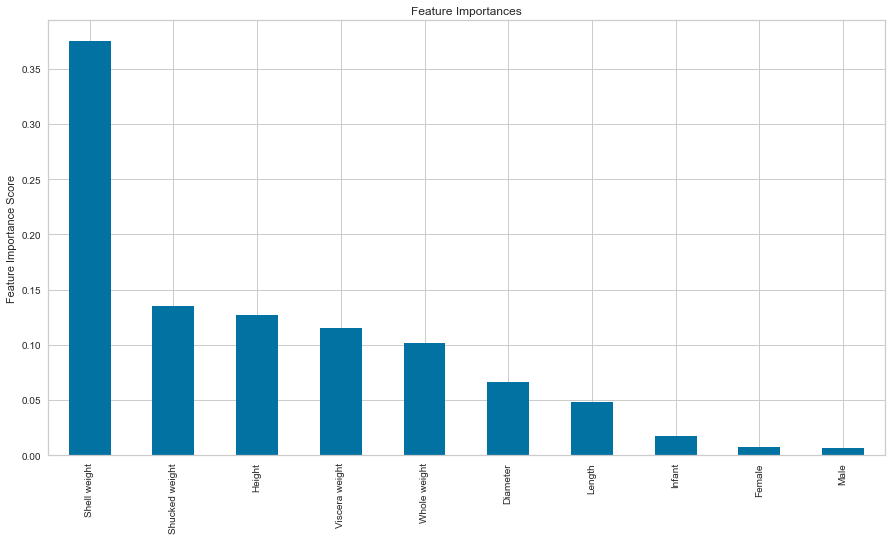

In [26]:
rmse = ModelRMSE(tunedModel, X_train, y_train, cv, scorerObject)

print('Cross Validation RMSE : Mean - %.3f | Std - %.3f | Min - %.3f | Max - %.3f' % (np.mean(rmse),np.std(rmse),np.min(rmse),np.max(rmse)))

fig = plt.figure(figsize=(15,8))
feat_imp = pd.Series(tunedModel.feature_importances_, X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

The most important feature in predicting abalone age according to our model is the Shell weight. Abalone [grow by adding rings of calcium carbonate to their shell](http://www.marinebio.net/marinescience/06future/abrepro.htm), and the more rings, the larger the weight.

The dimensions are of the same relative importance, while the most important Sex is Infant. The differences in Sex align with our initial assumptions. There is little difference between Female and Male, but the Infants skew younger which is a useful predictor. 

In a business setting we would provide the subject matter expert with these results and get their opinion. 

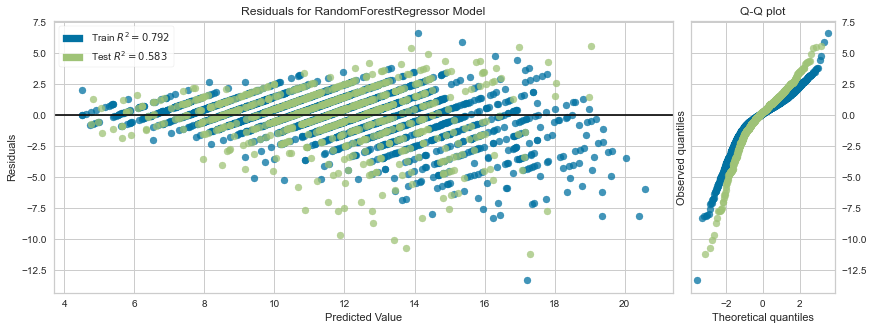

In [27]:
fig = plt.figure(figsize=(14,5))
visualizer = ResidualsPlot(tunedModel, hist=False, qqplot=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()
plt.show()

The residual and Predicted vs Actual plots highlight the source of most of the model error. The ages in the dataset are discrete, while our model predicts across a continuous age. This produces the stratified lines in both plots. The actual age of snails if measured from birth would likely line up well with our model, but instead the data is bucketed into a discrete number of rings. Utilizing a classifier instead of a regression algorithm would reduce some of this error by also bucketing the predictions on discrete ages. 

The test data doesn't fit as well as the train data, which could be a sign of some overfitting. The R<sup>2</sup> score is relatively close between the train and test sets, as is the visual spread of the residuals. If this was a larger concern we could adjust the training/test data split, or the cross validation.

# 6. Summary

The ages of abalone are able to be predicted from our model with a RMSE of 2.14 years. Assuming this level of accuracy is sufficient for our customers (likely the scientists studying the abalone) this approach when put into production would greatly speed up data collection due to the reduction in time required to determine the age of the abalone directly.